# Imports

In [61]:




import tensorflow as tf

import numpy as np
from keras.datasets import mnist

from time import time 
import foolbox as fb
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.optimizers import adam_v2
from keras.losses import categorical_crossentropy
from tensorflow.keras.models import load_model
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import neural_structured_learning as nsl
import numpy as np
import tensorflow as tf
import random as random


tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


# Define variables

In [41]:
epsilon=0.3
batch_size=1024
epochs=20
filters=32
kernel_size=3



# Create/train vanilla model

In [42]:
#ResNet implementation
def create_and_train_model():
      print("creating vanilla model...")
      (x_train, y_train), (x_test, y_test) = mnist.load_data()

      img_rows = img_cols = 28
      x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
      x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

      x_train = x_train.astype('float32')
      x_test = x_test.astype('float32')
      x_train /= 255
      x_test /= 255

      model = Sequential()
      model.add(Conv2D(filters, (kernel_size, kernel_size), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
      model.add(MaxPooling2D((2, 2)))
      model.add(Conv2D(filters*2, (kernel_size, kernel_size), activation='relu', kernel_initializer='he_uniform'))
      model.add(Conv2D(filters*2, (kernel_size, kernel_size), activation='relu', kernel_initializer='he_uniform'))
      model.add(MaxPooling2D((2, 2)))
      model.add(Flatten())
      model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
      model.add(Dense(10, activation='softmax'))
	# compile model
	
      model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
      print("training vanilla model...")
      history=model.fit(x_train,to_categorical(y_train, 10),
                  batch_size=batch_size,
                  epochs=epochs,
                  shuffle=True,
                  verbose=0,
                  )


      # plt.plot(history.history['accuracy'])
      # plt.xlabel('Epoch')
      # plt.ylabel('Accuracy')
      # print('Training time:',time()-begin)
      
      return model
    

model=create_and_train_model()
model.save("vanilla_model")






creating vanilla model...
training vanilla model...
INFO:tensorflow:Assets written to: vanilla_model\assets


# Attack Vanilla Model and Retrain with adversarial examples iteratively
Result is ptb_trained_model

Takes a few minutes

Perturbation-based adversarial examples before retraining


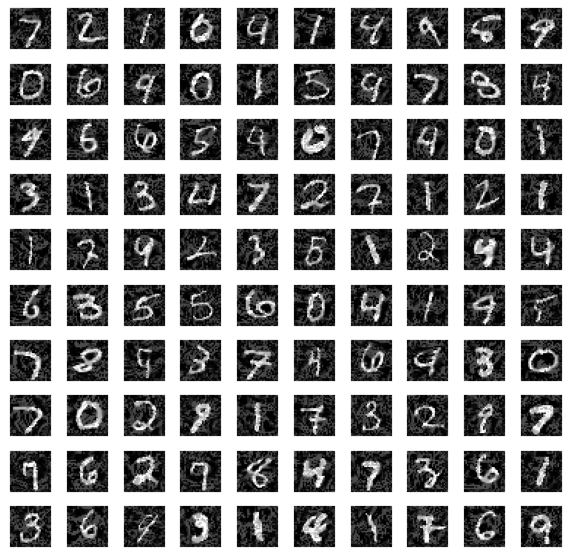

4/4 [==============================] - 0s 3ms/step - loss: 0.0147 - accuracy: 0.9900
BEFORE RETRAIN: Accuracy on clean testing data 0.9900000095367432
4/4 [==============================] - 0s 6ms/step - loss: 18.4487 - accuracy: 0.0000e+00
BEFORE RETRAIN: Accuracy on perturbation-based adversarial examples 0.0
Attacking...
0 : Success_rate:  1.0
1 : Success_rate:  1.0
2 : Success_rate:  1.0
3 : Success_rate:  0.96
4 : Success_rate:  1.0
5 : Success_rate:  0.99
6 : Success_rate:  0.89
7 : Success_rate:  0.97
8 : Success_rate:  0.91
9 : Success_rate:  0.98
10 : Success_rate:  0.99
11 : Success_rate:  0.87
12 : Success_rate:  0.89
13 : Success_rate:  0.97
14 : Success_rate:  0.92
15 : Success_rate:  0.96
16 : Success_rate:  0.99
17 : Success_rate:  0.91
18 : Success_rate:  0.86
19 : Success_rate:  0.88
20 : Success_rate:  0.87
21 : Success_rate:  0.85
22 : Success_rate:  0.85
23 : Success_rate:  0.87
24 : Success_rate:  0.86
25 : Success_rate:  0.92
26 : Success_rate:  0.95
27 : Success_

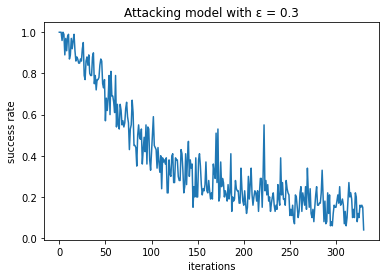

32/32 [==============================] - 0s 3ms/step - loss: 0.1216 - accuracy: 0.9650
AFTER RETRAIN: Accuracy on clean testing data 0.9649999737739563
Attack after retraining - success_rate:  0.14
32/32 [==============================] - 0s 3ms/step - loss: 0.5153 - accuracy: 0.8630
AFTER RETRAIN: Accuracy on perturbation based adversarial examples 0.8629999756813049
Final perturbation-based adversarial examples after retraining


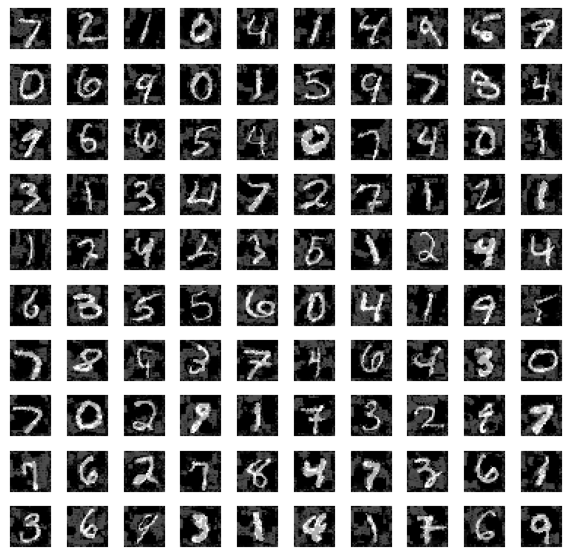

INFO:tensorflow:Assets written to: ptb_trained_model\assets


In [69]:

#threshold for success_rate on attacks
threshold=0.05


#get Model
model=load_model("vanilla_model")



#get MNIST data and prepare
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows = img_cols = 28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_train, x_test = x_train / 255.0, x_test / 255.0



#define variables needed for attacks
x_attack_to_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_attack_to_train=x_attack_to_train[:,:,:,np.newaxis]
y_attack_to_train=tf.convert_to_tensor(y_train, dtype=tf.int32)

x_attack_to_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
x_attack_to_test=x_attack_to_test[:,:,:,np.newaxis]
y_attack_to_test=tf.convert_to_tensor(y_test, dtype=tf.int32)



#get perturbated images for showing purposes
print("Perturbation-based adversarial examples before retraining")
fmodel=fb.models.tensorflow.TensorFlowModel(model, bounds=(0,1))      
attack = fb.attacks.projected_gradient_descent.LinfProjectedGradientDescentAttack(abs_stepsize=0.01)
_,advs_to_test, success=attack(fmodel, x_attack_to_test[0:100], y_attack_to_test[0:100], epsilons=epsilon)
advs_to_test=tf.keras.backend.get_value(advs_to_test)
_, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(100):
    temp = np.ones((32, 32, 3), dtype=np.float32)
    x=advs_to_test[i]
    x=x[:,:,0]
    temp[2:-2, 2:-2, 0] = x
    temp[2:-2, 2:-2, 1] = x
    temp[2:-2, 2:-2, 2] = x
    ax[i//10, i%10].imshow(temp)
    ax[i//10, i%10].axis('off')
plt.show()



#Evaluate clean accuracy on vanilla model
acc = model.evaluate(x_test[0:100], to_categorical(y_test[0:100]))
print('BEFORE RETRAIN: Accuracy on clean testing data', acc[1])

#Evaluate accuracy against perturbation-based adversarial examples on vanilla model
acc = model.evaluate(advs_to_test[0:100], to_categorical(y_test[0:100]))
print('BEFORE RETRAIN: Accuracy on perturbation-based adversarial examples', acc[1])



#Attack and retraining phase
success_arr=[]
x_axis=[]
success_rate=1
k=0
attack = fb.attacks.projected_gradient_descent.LinfProjectedGradientDescentAttack()
print("Attacking...")

# while success_rate>=threshold:    
while success_rate>threshold:   
    
    #generate random indexes. Otherwise, model won't be robust
    start=random.randint(0,59900)

    #attack model
    fmodel=fb.models.tensorflow.TensorFlowModel(model, bounds=(0,1))   
    _,advs, success=attack(fmodel, x_attack_to_train[start:start+100], y_attack_to_train[start:start+100], epsilons=epsilon)

    #get success rate of attack
    success_rate=tf.keras.backend.get_value(success).mean(axis=-1).round(2)
    print(k,": Success_rate: ",success_rate)  
    success_arr.append(success_rate)

    #Retrain model with generated perturbation-based adversarial examples
    x=tf.keras.backend.get_value(advs)
    x = x[:, :, :, :, 0]
    model.fit(x,to_categorical(y_train[start:start+100]),
        batch_size=batch_size,
        epochs=epochs,
        verbose=0
        )

    x_axis.append(k)
    k+=1  
    


#print summary of success rates
fig, ax = plt.subplots()
ax.plot(x_axis,success_arr)
plt.title("Attacking model with ε = {}".format(epsilon))
plt.xlabel('iterations')
plt.ylabel('success rate')
plt.show()



#Evaluate clean accuracy on ptb_trained_model
acc = model.evaluate(x_test[0:1000], to_categorical(y_test[0:1000]))
print('AFTER RETRAIN: Accuracy on clean testing data', acc[1])


#generate final perturbation-based adversarial examples on test images
fmodel=fb.models.tensorflow.TensorFlowModel(model, bounds=(0,1))
attack = fb.attacks.projected_gradient_descent.LinfProjectedGradientDescentAttack(abs_stepsize=0.01)
_,advs_to_test, success=attack(fmodel, x_attack_to_test[0:1000], y_attack_to_test[0:1000], epsilons=epsilon)
success_rate=tf.keras.backend.get_value(success).mean(axis=-1).round(2)
print("Attack after retraining - success_rate: ",success_rate)

np.save("data/ptb_test_linfPGD",advs_to_test)

x=tf.keras.backend.get_value(advs_to_test)
test=x[:, :, :, 0]

#Evaluate accuracy against perturbation-based adversarial examples on ptb_trained_model
acc = model.evaluate(test, to_categorical(y_test[0:1000]))
print('AFTER RETRAIN: Accuracy on perturbation based adversarial examples', acc[1])



#show final perturbation-based adversarial examples
print("Final perturbation-based adversarial examples after retraining")
_, ax = plt.subplots(10, 10, figsize=(10, 10))
imgs = x[:, :, :, 0]
for i in range(100):
    temp = np.ones((32, 32, 3), dtype=np.float32)
    temp[2:-2, 2:-2, 0] = imgs[i]
    temp[2:-2, 2:-2, 1] = imgs[i]
    temp[2:-2, 2:-2, 2] = imgs[i]
    ax[i//10, i%10].imshow(temp)
    ax[i//10, i%10].axis('off')
plt.show()


model.save("ptb_trained_model")

# Test models

ATTACK BASED ON VANILLA MODEL:
Attack success_rate:  1.0


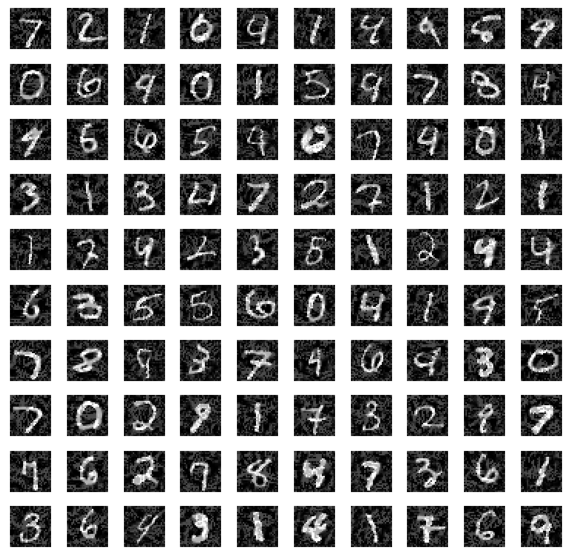

Evaluating Vanilla Model:
32/32 [==============================] - 0s 4ms/step - loss: 0.0346 - accuracy: 0.9870
Clean accuracy:  0.9869999885559082
32/32 [==============================] - 0s 5ms/step - loss: 18.5522 - accuracy: 0.0000e+00
Accuracy on perturbation-based adversarial examples:  0.0

Evaluating ptb_trained_model:
32/32 [==============================] - 0s 5ms/step - loss: 0.1216 - accuracy: 0.9650
Clean accuracy:  0.9649999737739563
32/32 [==============================] - 0s 4ms/step - loss: 0.1921 - accuracy: 0.9490
Accuracy on perturbation-based adversarial examples:  0.9490000009536743

ATTACK BASED ON PTB_TRAINED MODEL:
Attack success_rate:  0.13


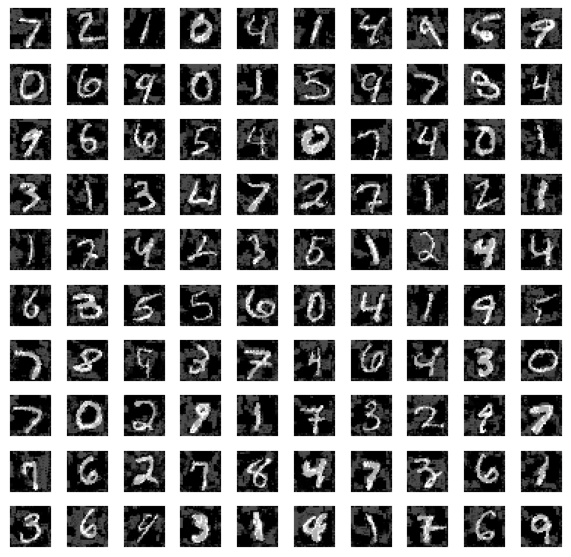

Evaluating Vanilla Model:
32/32 [==============================] - 0s 4ms/step - loss: 0.0346 - accuracy: 0.9870
Clean accuracy:  0.9869999885559082
32/32 [==============================] - 0s 4ms/step - loss: 0.3854 - accuracy: 0.9000
Accuracy on perturbation-based adversarial examples:  0.8999999761581421

Evaluating ptb_trained_model:
32/32 [==============================] - 0s 4ms/step - loss: 0.1216 - accuracy: 0.9650
Clean accuracy:  0.9649999737739563
32/32 [==============================] - 0s 4ms/step - loss: 0.5076 - accuracy: 0.8660
Accuracy on perturbation-based adversarial examples:  0.8659999966621399


In [70]:

vanilla_model=load_model("vanilla_model")
ptb_trained_model=load_model("ptb_trained_model")

def attack_and_evaluate(model):

    x_attack_to_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
    x_attack_to_test=x_attack_to_test[:,:,:,np.newaxis]
    y_attack_to_test=tf.convert_to_tensor(y_test, dtype=tf.int32)
    fmodel=fb.models.tensorflow.TensorFlowModel(model, bounds=(0,1))
    attack = fb.attacks.projected_gradient_descent.LinfProjectedGradientDescentAttack(abs_stepsize=0.01)
    _,advs_to_test, success=attack(fmodel, x_attack_to_test[0:1000], y_attack_to_test[0:1000], epsilons=epsilon)
    success_rate=tf.keras.backend.get_value(success).mean(axis=-1).round(2)
    print("Attack success_rate: ",success_rate)
    x=tf.keras.backend.get_value(advs_to_test)
    ptb_test=x[:, :, :, 0]

    _, ax = plt.subplots(10, 10, figsize=(10, 10))
    imgs = x[:, :, :, 0]
    for i in range(100):
        temp = np.ones((32, 32, 3), dtype=np.float32)
        temp[2:-2, 2:-2, 0] = imgs[i]
        temp[2:-2, 2:-2, 1] = imgs[i]
        temp[2:-2, 2:-2, 2] = imgs[i]
        ax[i//10, i%10].imshow(temp)
        ax[i//10, i%10].axis('off')
    plt.show()


    print("Evaluating Vanilla Model:")
    acc = vanilla_model.evaluate(x_test[0:1000], to_categorical(y_test[0:1000]))
    print("Clean accuracy: ",acc[1])

    acc = vanilla_model.evaluate(ptb_test[0:1000], to_categorical(y_test[0:1000]))
    print("Accuracy on perturbation-based adversarial examples: ",acc[1])



    print("")
    print("Evaluating ptb_trained_model:")
    acc = ptb_trained_model.evaluate(x_test[0:1000], to_categorical(y_test[0:1000]))
    print("Clean accuracy: ",acc[1])

    acc = ptb_trained_model.evaluate(ptb_test[0:1000], to_categorical(y_test[0:1000]))
    print("Accuracy on perturbation-based adversarial examples: ",acc[1])




print("ATTACK BASED ON VANILLA MODEL:")
attack_and_evaluate(vanilla_model)

print("")
print("ATTACK BASED ON PTB_TRAINED MODEL:")
attack_and_evaluate(ptb_trained_model)





# Testing invariance based adversarial examples from paper (100 labels from 40 human participants)


In [ ]:
#Get model untrained with adversarial examples...
model=load_model("vanilla_model")


#get invariance-based adversarial examples generated from tramer et al.
adv_03 = np.load('invariance_examples/linf/automated_eps04.npy').astype(np.float32) / 255.
#get the human labels from tramer et.al
labels_h_03 = np.load('invariance_examples/linf/automated_eps04_labels.npy')

labels_h_03=to_categorical(labels_h_03)




print("INVARIANCE BASED ADVERSARIAL IMAGES")
disagreeing_human=0

#let my model predict with the invariance-based adversarial examples
predictions=model.predict(adv_03)
_, ax = plt.subplots(10, 10, figsize=(35, 35))
for i in range(100):
    temp = np.ones((32, 32, 3), dtype=np.float32)
    x=adv_03[i]
    # x=x[:,:,0]
    human_labeled=np.argmax(labels_h_03[i])
    temp[2:-2, 2:-2, 0] = x
    temp[2:-2, 2:-2, 1] = x
    temp[2:-2, 2:-2, 2] = x
    ax[i//10, i%10].imshow(temp)
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].set_title("model: {} human: {}".format(np.argmax(predictions[i]), human_labeled))
    #check if human prediction differs from model prediction
    if human_labeled!=np.argmax(predictions[i]):
        disagreeing_human+=1

plt.show()

print("Human disagreeing: {}%".format(disagreeing_human/100*100))



# Save random 200 indices in file...
Needed to generate invariance based adversarial examples

In [ ]:
rand_indices = np.random.randint(0,9999,(200))
np.save("npy/random_indices200", rand_indices)





# Find nearest Neighbours (Takes a lot of computation)

In [ ]:
from keras.datasets import mnist
import numpy as np
from sklearn.neighbors import NearestNeighbors
from itertools import product
from scipy.ndimage.interpolation import rotate, shift

#  Load the MNIST data. 100 randomly chosen test points
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
idxs = np.load("npy/random_indices200.npy")
assert len(idxs) == 200
test_xs = X_test[idxs]
test_ys = Y_test[idxs]

# build a nearest neighbors classifier per class
N = 1
all_NNs = []

for i in range(10):
    #Reshape to 1D (28*28=784)
    X = X_train[Y_train == i].reshape(-1, 784)
    print("X: ", np.shape(X))
    nn = NearestNeighbors(n_neighbors=N)
   
    nn.fit(X)
    all_NNs.append(nn)
print(all_NNs)



# Rotation-translation parameters
limits = [3, 3, 30]
granularity = [5, 5, 31]
grid = list(product(*list(np.linspace(-l, l, num=g) for l, g in zip(limits, granularity))))

# tries all rotation-translations of the input and returns the closest neighbor from each class
def get_best_neighbors(x, y):
    xs = [shift(rotate(x, r, reshape=False), (tx, ty)).reshape(784) for (tx, ty, r) in grid]
    xs = np.asarray(xs.copy())
    
    nns = []
    y_nns = []
    grids_nn = []
    
    # find a nearest neighbor in each class
    for i in range(10):
        if i != y:
            X = X_train[Y_train == i]
            Y = Y_train[Y_train == i]
            distances, indices = all_NNs[i].kneighbors(xs, n_neighbors=1)

            best = np.argmin(np.reshape(distances, -1))
            best_idx = np.reshape(indices, -1)[best]
            nns.append(X[best_idx])
            y_nns.append(Y[best_idx])
            
            # store the inverse rotation+translation to be applied to the target
            grids_nn.append(-np.asarray(grid[best]))
    
    return nns, y_nns, grids_nn


all_nns = []
all_y_nns = []
all_grids_nns = []

# find nearest neighbors for some test inputs (this takes a little while)
for i in range(len(idxs)):
    if i % 10 == 0:
        print("{}/{} done".format(i, len(idxs)))
    x = test_xs[i]
    y = test_ys[i]

    # find the nearest neighbors for each class, with the corresponding rotation and translation
    nns, y_nns, grids_nns = get_best_neighbors(x, y)
    nn_advs = [shift(rotate(nn, r, reshape=False), (tx, ty)) for (nn, (tx, ty, r)) in zip(nns, grids_nns)]
    all_nns.append(nn_advs)
    all_y_nns.append(y_nns)
    all_grids_nns.append(np.asarray(grids_nns))

# Save nearest Neighbours

In [ ]:
# save everything!
np.save("X_test_200.npy", test_xs)
np.save("all_nns.npy", np.asarray(all_nns))
np.save("all_y_nns.npy", np.asarray(all_y_nns))
np.save("all_grids_nns.npy", np.asarray(all_grids_nns))

print(np.shape(test_xs))

In [ ]:
def linf_attack(x, nn_adv, eps=0.3):
    x_adv = x.copy().astype(np.float32)
    nn_adv = nn_adv.astype(np.float32)
    
    # if possible, change the pixels to the target value
    idx = np.where((np.abs(nn_adv - x) <= eps*255.) & (x > 0))
    x_adv[idx] = nn_adv[idx]
    
    # otherwise, go as close as possible
    idx = np.where(np.abs(nn_adv - x) > eps*255.)
    sign = np.sign(nn_adv - x)
    x_adv[idx] += sign[idx] * eps * 255.
    
    x_adv = np.clip(x_adv, x.astype(np.float32) - eps*255, x.astype(np.float32) + eps*255)
    x_adv = np.clip(x_adv, 0, 255.)
    
    return x_adv

# Generate invariance based adversarial examples

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
all_nns=np.load("all_nns.npy")
all_y_nns=np.load("all_y_nns.npy")
all_grids_nns=np.load("all_grids_nns.npy")
test_xs=np.load("X_test_200.npy")
idxs = np.load("npy/random_indices200.npy")
assert len(idxs) == 200

test_ys = Y_test[idxs]
# fig, ax = plt.subplots(max(len(all_nns), 2), len(all_nns[0])+2, 
#                        figsize=(10*2, len(all_nns)*1.5))
# [a.axis('off') for a in np.asarray(ax).reshape(-1)]

# manually chosen target classes for each source class
targets = {
    0: [4, 6, 8, 9],
    1: [4, 6, 7, 9],
    2: [8],
    3: [8],
    4: [8, 9],
    5: [3, 8],
    6: [0],
    7: [2, 3],
    8: [3],
    9: [3, 4, 5]
}

best_y_advs = []
best_targets = []
best_advs = []

for i in range(len(all_nns)):
    x = test_xs[i]
    y = test_ys[i]
    # ax[i, 0].imshow(255-x, cmap='gray', vmin=0, vmax=255)
    
    best_x_adv = None
    best_nn_adv = None
    amount_removed = []
    amount_added = []
    rot = []
    best_y = None
    min_removed = np.inf
    for j in range(len(all_nns[i])):
        nn_adv = all_nns[i][j]
        y_nn = all_y_nns[i][j]
        x_adv = linf_attack(x, nn_adv, eps=0.3)
        # ax[i, 1+y_nn].imshow(255-x_adv, cmap='gray', vmin=0, vmax=255)
        
        # retain the target that required the least amount of pixels to be "removed"
        curr_rot = np.abs(all_grids_nns[i][j][-1])
        curr_removed = np.sum(np.abs(np.maximum(x/255. - x_adv/255., 0)))
        
        if y_nn in targets[y] and curr_removed < min_removed:
            min_removed = curr_removed
            best_y = y_nn
            best_x_adv = x_adv
            best_nn_adv = (nn_adv, y_nn)
                
    best_targets.append(best_nn_adv)
    best_advs.append(best_x_adv)
    best_y_advs.append(best_y)
# print("BEST Y: ", np.shape(best_advs))
# print("BEST X: ",np.shape(best_y_advs))

_, ax = plt.subplots(20, 10, figsize=(25, 25))
j=0
for i in range(200):
    x=best_advs[i]
    if i>0:
        if i%10==0:
            j+=1
    # print("ax[{},{}]".format(j, i%10))
    
    ax[j, i%10].imshow(x,cmap='gray')
    ax[j, i%10].axis('off')
    ax[j,i%10].set_title(best_y_advs[i])
# for i in range(200):
#     temp = np.ones((32, 32, 3), dtype=np.float32)
#     x=best_advs[i]
#     # x=x[:,:,0]
#     # temp[2:-2, 2:-2, 0] = x
#     # temp[2:-2, 2:-2, 1] = x
#     # temp[2:-2, 2:-2, 2] = x
#     print("ax[{},{}]".format(i//20, i%10))
#     ax[i//20, i%10].imshow(x)
#     ax[i//20, i%10].axis('off')
_.tight_layout(pad=1.0)
plt.show()

np.save("npy/invariance-based_adversarial_examples", best_advs)
np.save("npy/invariance-based_adversarial_examples_labels", best_y_advs)
